# Baseline Flat Classification

This notebook trains a **flat (non-hierarchical) classifier** on the merged 3D MedMNIST datasets for comparison with the hierarchical approach.

The flat classifier predicts the fine-grained label directly without the intermediate region classification step.

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from config import (
    DEVICE, DATA_CONFIG, MODEL_CONFIG, TRAINING_CONFIG,
    PATHS, set_seed, DEFAULT_MERGED_DATASETS
)
from utils.data_loader import create_hierarchical_dataset
from utils.cnn_3d_models import get_3d_model
from utils.trainer import Trainer

set_seed(42)
print(f"Device: {DEVICE}")

GPU detected: NVIDIA GeForce RTX 3070
GPU memory: 8.21 GB
Platform: NVIDIA CUDA
Device: cuda


## 1. Load Merged Dataset

In [2]:
# Load all 5 merged datasets
print(f"Loading datasets: {DEFAULT_MERGED_DATASETS}")

train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print("\n" + "="*60)
print("MERGED DATASET INFO")
print("="*60)
print(f"Datasets: {dataset_info['datasets_included']}")
print(f"Train samples: {dataset_info['train_samples']:,}")
print(f"Val samples: {dataset_info['val_samples']:,}")
print(f"Test samples: {dataset_info['test_samples']:,}")
print(f"Fine classes: {dataset_info['num_fine_classes']}")

Loading datasets: ['organ', 'nodule', 'adrenal', 'fracture', 'vessel']
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verif

## 2. Create Wrapper DataLoaders for Flat Training

The hierarchical dataset returns `(img, coarse_label, fine_label)`. For flat training, we only need `(img, fine_label)`.

In [3]:
class FlatDataLoaderWrapper:
    """Wrapper that extracts only (img, fine_label) from hierarchical dataloader."""
    def __init__(self, hierarchical_loader):
        self.loader = hierarchical_loader
    
    def __iter__(self):
        for imgs, coarse_labels, fine_labels in self.loader:
            yield imgs, fine_labels
    
    def __len__(self):
        return len(self.loader)

# Create flat loaders
flat_train_loader = FlatDataLoaderWrapper(train_loader)
flat_val_loader = FlatDataLoaderWrapper(val_loader)
flat_test_loader = FlatDataLoaderWrapper(test_loader)

print("\n✓ Flat data loaders created")


✓ Flat data loaders created


## 3. Build Flat Classifier

In [4]:
# Create flat classifier
num_classes = dataset_info['num_fine_classes']
architecture = MODEL_CONFIG['architecture']

model = get_3d_model(
    model_name=architecture,
    num_classes=num_classes
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nFlat classifier created:")
print(f"  Architecture: {architecture}")
print(f"  Number of classes: {num_classes}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")


Flat classifier created:
  Architecture: enhanced
  Number of classes: 11
  Total parameters: 2,095,147
  Trainable parameters: 2,095,147


## 4. Train Flat Classifier

In [5]:
# Create trainer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=TRAINING_CONFIG['scheduler_step_size'],
    gamma=TRAINING_CONFIG['scheduler_gamma']
)

trainer = Trainer(
    model=model,
    train_loader=flat_train_loader,
    val_loader=flat_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler
)

# Total epochs = coarse + fine epochs for fair comparison
total_epochs = TRAINING_CONFIG['coarse_epochs'] + TRAINING_CONFIG['fine_epochs']
print(f"Training for {total_epochs} epochs...")

Training for 50 epochs...


In [6]:
# Train
history = trainer.train(num_epochs=total_epochs)

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)


Epoch 1/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 52.37it/s]


Train Loss: 1.0853, Train Acc: 0.6205
Val Loss: 1.5463, Val Acc: 0.5933
New best validation accuracy: 0.5933

Epoch 2/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 47.25it/s]


Train Loss: 1.0039, Train Acc: 0.6309
Val Loss: 0.9901, Val Acc: 0.6003
New best validation accuracy: 0.6003

Epoch 3/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 49.71it/s]


Train Loss: 0.9560, Train Acc: 0.6344
Val Loss: 0.9781, Val Acc: 0.5961

Epoch 4/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 49.85it/s]


Train Loss: 0.9308, Train Acc: 0.6343
Val Loss: 0.8985, Val Acc: 0.6351
New best validation accuracy: 0.6351

Epoch 5/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 46.27it/s]


Train Loss: 0.8972, Train Acc: 0.6443
Val Loss: 0.9454, Val Acc: 0.6226

Epoch 6/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 51.46it/s]


Train Loss: 0.8782, Train Acc: 0.6512
Val Loss: 1.0277, Val Acc: 0.6574
New best validation accuracy: 0.6574

Epoch 7/50


Validation: 100%|██████████| 90/90 [00:02<00:00, 44.53it/s]


Train Loss: 0.8619, Train Acc: 0.6522
Val Loss: 0.9330, Val Acc: 0.6393

Epoch 8/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 50.67it/s]


Train Loss: 0.8581, Train Acc: 0.6545
Val Loss: 0.7621, Val Acc: 0.6755
New best validation accuracy: 0.6755

Epoch 9/50


Validation: 100%|██████████| 90/90 [00:02<00:00, 43.97it/s]


Train Loss: 0.8340, Train Acc: 0.6609
Val Loss: 0.8238, Val Acc: 0.6755

Epoch 10/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 49.13it/s]


Train Loss: 0.8216, Train Acc: 0.6640
Val Loss: 0.8664, Val Acc: 0.6783
New best validation accuracy: 0.6783

Epoch 11/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 50.07it/s]


Train Loss: 0.7794, Train Acc: 0.6764
Val Loss: 0.7460, Val Acc: 0.6950
New best validation accuracy: 0.6950

Epoch 12/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 49.04it/s]


Train Loss: 0.7709, Train Acc: 0.6790
Val Loss: 0.7815, Val Acc: 0.6643

Epoch 13/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 46.90it/s]


Train Loss: 0.7556, Train Acc: 0.6836
Val Loss: 0.6654, Val Acc: 0.7103
New best validation accuracy: 0.7103

Epoch 14/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 48.63it/s]


Train Loss: 0.7392, Train Acc: 0.6917
Val Loss: 0.6564, Val Acc: 0.7270
New best validation accuracy: 0.7270

Epoch 15/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 47.00it/s]


Train Loss: 0.7201, Train Acc: 0.6961
Val Loss: 0.6245, Val Acc: 0.7340
New best validation accuracy: 0.7340

Epoch 16/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 51.00it/s]


Train Loss: 0.7025, Train Acc: 0.7026
Val Loss: 0.6362, Val Acc: 0.7270

Epoch 17/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 46.84it/s]


Train Loss: 0.6902, Train Acc: 0.7102
Val Loss: 0.6064, Val Acc: 0.7312

Epoch 18/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 52.37it/s]


Train Loss: 0.6831, Train Acc: 0.7116
Val Loss: 0.5927, Val Acc: 0.7451
New best validation accuracy: 0.7451

Epoch 19/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 49.83it/s]


Train Loss: 0.6650, Train Acc: 0.7169
Val Loss: 0.5890, Val Acc: 0.7437

Epoch 20/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 50.98it/s]


Train Loss: 0.6710, Train Acc: 0.7077
Val Loss: 0.5361, Val Acc: 0.7744
New best validation accuracy: 0.7744

Epoch 21/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 50.79it/s]


Train Loss: 0.6347, Train Acc: 0.7269
Val Loss: 0.5222, Val Acc: 0.7772
New best validation accuracy: 0.7772

Epoch 22/50


Validation: 100%|██████████| 90/90 [00:02<00:00, 44.14it/s]


Train Loss: 0.6304, Train Acc: 0.7331
Val Loss: 0.5111, Val Acc: 0.7632

Epoch 23/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 51.02it/s]


Train Loss: 0.6242, Train Acc: 0.7308
Val Loss: 0.5426, Val Acc: 0.7716

Epoch 24/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 51.24it/s]


Train Loss: 0.6029, Train Acc: 0.7382
Val Loss: 0.5101, Val Acc: 0.7744

Epoch 25/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 50.04it/s]


Train Loss: 0.6128, Train Acc: 0.7360
Val Loss: 0.5111, Val Acc: 0.7674

Epoch 26/50


Validation: 100%|██████████| 90/90 [00:02<00:00, 44.18it/s]


Train Loss: 0.6108, Train Acc: 0.7304
Val Loss: 0.5266, Val Acc: 0.7549

Epoch 27/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 45.63it/s]


Train Loss: 0.6112, Train Acc: 0.7350
Val Loss: 0.5512, Val Acc: 0.7730

Epoch 28/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 47.45it/s]


Train Loss: 0.5965, Train Acc: 0.7433
Val Loss: 0.5064, Val Acc: 0.7786
New best validation accuracy: 0.7786

Epoch 29/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 46.00it/s]


Train Loss: 0.5970, Train Acc: 0.7413
Val Loss: 0.5254, Val Acc: 0.7688

Epoch 30/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 45.10it/s]


Train Loss: 0.5941, Train Acc: 0.7364
Val Loss: 0.4995, Val Acc: 0.7799
New best validation accuracy: 0.7799

Epoch 31/50


Validation: 100%|██████████| 90/90 [00:02<00:00, 44.72it/s]


Train Loss: 0.5841, Train Acc: 0.7440
Val Loss: 0.5330, Val Acc: 0.7646

Epoch 32/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 46.45it/s]


Train Loss: 0.5721, Train Acc: 0.7522
Val Loss: 0.4854, Val Acc: 0.7660

Epoch 33/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 46.16it/s]


Train Loss: 0.5696, Train Acc: 0.7478
Val Loss: 0.4768, Val Acc: 0.7827
New best validation accuracy: 0.7827

Epoch 34/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 45.64it/s]


Train Loss: 0.5647, Train Acc: 0.7484
Val Loss: 0.4697, Val Acc: 0.7897
New best validation accuracy: 0.7897

Epoch 35/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 48.87it/s]


Train Loss: 0.5652, Train Acc: 0.7456
Val Loss: 0.5011, Val Acc: 0.7786

Epoch 36/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 46.89it/s]


Train Loss: 0.5669, Train Acc: 0.7529
Val Loss: 0.4887, Val Acc: 0.7841

Epoch 37/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 46.91it/s]


Train Loss: 0.5645, Train Acc: 0.7552
Val Loss: 0.4678, Val Acc: 0.7939
New best validation accuracy: 0.7939

Epoch 38/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 48.45it/s]


Train Loss: 0.5591, Train Acc: 0.7528
Val Loss: 0.5126, Val Acc: 0.7730

Epoch 39/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 46.39it/s]


Train Loss: 0.5560, Train Acc: 0.7508
Val Loss: 0.4728, Val Acc: 0.7897

Epoch 40/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 48.46it/s]


Train Loss: 0.5493, Train Acc: 0.7542
Val Loss: 0.4745, Val Acc: 0.7786

Epoch 41/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 49.46it/s]


Train Loss: 0.5485, Train Acc: 0.7584
Val Loss: 0.4580, Val Acc: 0.7925

Epoch 42/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 47.88it/s]


Train Loss: 0.5435, Train Acc: 0.7542
Val Loss: 0.4532, Val Acc: 0.7869

Epoch 43/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 45.73it/s]


Train Loss: 0.5364, Train Acc: 0.7609
Val Loss: 0.4505, Val Acc: 0.8148
New best validation accuracy: 0.8148

Epoch 44/50


Validation: 100%|██████████| 90/90 [00:02<00:00, 44.26it/s]


Train Loss: 0.5375, Train Acc: 0.7607
Val Loss: 0.4719, Val Acc: 0.7841

Epoch 45/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 49.74it/s]


Train Loss: 0.5300, Train Acc: 0.7584
Val Loss: 0.5846, Val Acc: 0.7660

Epoch 46/50


Validation: 100%|██████████| 90/90 [00:02<00:00, 44.92it/s]


Train Loss: 0.5350, Train Acc: 0.7660
Val Loss: 0.4516, Val Acc: 0.7994

Epoch 47/50


Validation: 100%|██████████| 90/90 [00:02<00:00, 44.77it/s]


Train Loss: 0.5272, Train Acc: 0.7618
Val Loss: 0.4548, Val Acc: 0.8036

Epoch 48/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 48.41it/s]


Train Loss: 0.5255, Train Acc: 0.7672
Val Loss: 0.4777, Val Acc: 0.7855

Epoch 49/50


Validation: 100%|██████████| 90/90 [00:02<00:00, 41.53it/s]


Train Loss: 0.5204, Train Acc: 0.7699
Val Loss: 0.4623, Val Acc: 0.7967

Epoch 50/50


Validation: 100%|██████████| 90/90 [00:01<00:00, 48.20it/s]

Train Loss: 0.5234, Train Acc: 0.7674
Val Loss: 0.5088, Val Acc: 0.7827

TRAINING COMPLETE!


## 5. Training Visualization

FileNotFoundError: [Errno 2] No such file or directory: './figures/baseline_training_history.png'

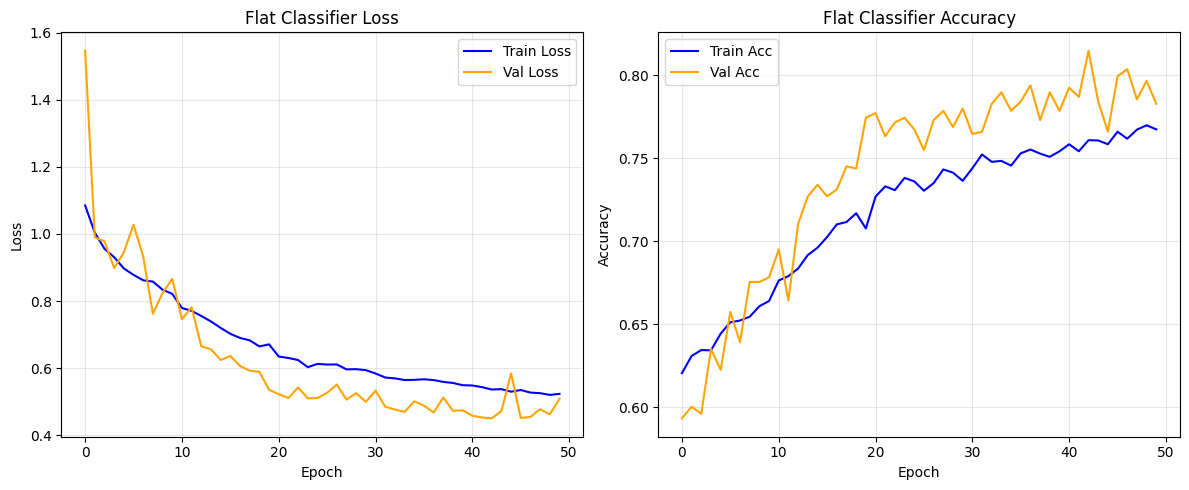

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Flat Classifier Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', color='blue')
axes[1].plot(history['val_acc'], label='Val Acc', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Flat Classifier Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{PATHS['figures']}/baseline_training_history.png", dpi=150)
plt.show()

## 6. Evaluation on Test Set

In [8]:
def evaluate_flat_model(model, test_loader, device):
    """Evaluate flat model on test set."""
    model.eval()
    
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Evaluating"):
            imgs = imgs.to(device, dtype=torch.float32)
            if imgs.max() > 1:
                imgs = imgs / 255.0
            
            labels = labels.squeeze(-1).long().to(device)
            
            outputs = model(imgs)
            preds = outputs.argmax(1)
            
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total if total > 0 else 0
    
    return {
        'accuracy': accuracy,
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
    }

In [9]:
# Evaluate
results = evaluate_flat_model(model, flat_test_loader, DEVICE)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"\nTest Accuracy: {results['accuracy']:.4f}")

Evaluating: 100%|██████████| 230/230 [00:02<00:00, 97.67it/s] 


TEST SET RESULTS

Test Accuracy: 0.6511


## 7. Save Model

In [11]:
import os
os.makedirs(PATHS['models'], exist_ok=True)

model_path = f"{PATHS['models']}baseline_flat_merged.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'dataset_info': dataset_info,
    'history': history,
    'test_results': results,
    'config': {
        'architecture': architecture,
        'num_classes': num_classes,
    }
}, model_path)

print(f"\n✓ Model saved to: {model_path}")


✓ Model saved to: ./models/baseline_flat_merged.pth


## 8. Summary

In [ ]:
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"\nDatasets used: {', '.join(dataset_info['datasets_included'])}")
print(f"Total training samples: {dataset_info['train_samples']:,}")
print(f"\nModel architecture: {architecture}")
print(f"Number of classes: {num_classes}")
print(f"Total parameters: {total_params:,}")
print(f"\nFinal Test Accuracy: {results['accuracy']:.4f}")
print(f"\nModel saved to: {model_path}")